# Transect of results and observations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import xarray as xr
import pandas as pd 
import cmocean
import forcing.modules.mapping_functions as mf
from datetime import datetime
import glob

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# results to plot:
year    = 2015
month   = 8
results_folder = '/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-2015_20230308/'

# colours:
land_color     = '#a9a7a2'
profile_colors = ['#ff4949', '#01b9ff']

#### Files:

In [3]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
bathy_masked = np.ma.masked_where((tmask> 0.1), tmask) 
mesh_depth   = mfile['nav_lev'].values

In [4]:
mesh       = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept = mesh['hdept'].values[0,imin:imax,jmin:jmax]

In [5]:
file1        = 'ANHA12_EXH006_1m_20150101_20151231_comp_201509-201509.nc'
Pb_model     = xr.open_dataset(f'{results_folder}{file1}')
Pb_dis       = Pb_model['dissolpb'].values[0,:,:,:]
sub_lat      = Pb_model['nav_lat'].values
sub_lon      = Pb_model['nav_lon'].values
depths_model = Pb_model['deptht'].values

Observations

In [6]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

Pb_data = Pb_data.rename(columns={"Depth.1": "Depth BB1", "Depth.2": "Depth BB2", "Depth.3": "Depth BB3", \
                        "Depth.4": "Depth CAA1", "Depth.5": "Depth CAA2", "Depth.6": "Depth CAA3", \
                        "Depth.7": "Depth CAA4", "Depth.8": "Depth CAA5", "Depth.9": "Depth CAA6", \
                        "Depth.10": "Depth CAA7", "Depth.11": "Depth CAA8", "Depth.12": "Depth CAA9", \
                        "Depth.13": "Depth CB1", "Depth.14": "Depth CB2", "Depth.15": "Depth CB3", \
                        "Depth.16": "Depth CB4"})

In [7]:
stn_names = Pb_data['Station names'].dropna().astype('str')
obs_lons  = Pb_data['station lon'].astype('float').dropna().values
obs_lats  = Pb_data['Station lat'].astype('float').dropna().values

#### Functions:

In [8]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [9]:
def fill_nans(input_var):
    vector = np.zeros(24)
    for i in range(0,24):
        if i < len(input_var):
            vector[i] = input_var[i]
        else:
            vector[i] = np.nan
    return vector

In [10]:
def search_depth(obs_depth, model_depths):
    k_list = np.array([])
    for i in range(0,len(obs_depth)):
        diff_list = np.array([])
        for n in range(0, len(model_depths)):
            diff = np.abs(obs_depth[i] - model_depths[n])
            diff_list = np.append(diff_list, diff)
        k = np.argmin(diff_list) # for list of indices associated with depths
        k_list = np.append(k_list, k)
    return k_list

In [11]:
def calculate_average(folder_ref_2015):
    # Calculate average over data files during cruise period:
    # 2015 GEOTRACES: 9 August - 15 September
    files_2015      = np.sort(glob.glob(f'{folder_ref_2015}ANHA12_EXH006_5d_20150101_20151231*'))
    start_date_2015 = datetime.strptime(f'2015-08-09', '%Y-%m-%d')
    end_date_2015   = datetime.strptime(f'2015-09-15', '%Y-%m-%d')

    file_list_2015 = []
    for file in files_2015:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            file_list_2015.append(file)

    dpb_2015 = np.zeros((50,isize,jsize))
    days = 0
    for file in file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dpb_2015 = dpb_2015 + ds['dissolpb'].values[0,:,:,:]

    pb_dis_ref_2015 = dpb_2015 / len(file_list_2015)
    
    return pb_dis_ref_2015

#### Calculations

In [12]:
# calculate average over dates of observations:
dissolved_Pb = calculate_average(results_folder)*1e12

In [13]:
transect_names = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', '', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3', \
                 '', 'BB3', '', 'BB1']

transect_distances = np.zeros(len(transect_names))
transect_lons      = np.zeros(len(transect_names)); transect_lats = np.zeros(len(transect_names));
transect_dPb       = np.zeros((26,len(transect_names)))
transect_depths    = np.zeros((26,len(transect_names)))
for k,name in enumerate(transect_names):
    if name=='' and k < 8:
        transect_lons[k] = -95.128357
        transect_lats[k] = 74.313002
    elif name=='' and k > 8 and k < 14:
        transect_lons[k] = -76.495545
        transect_lats[k] = 73.658423
    elif name=='' and k >= 14:        
        transect_lons[k] = -63.927186
        transect_lats[k] = 70.355341
    else:
        transect_lons[k] = obs_lons[stn_names==name]
        transect_lats[k] = obs_lats[stn_names==name]
    
    transect_distances[k] = haversine(transect_lons[0], transect_lats[0], transect_lons[k], transect_lats[k])
    try:
        transect_dPb[:,k]     = Pb_data[name].astype('float').values
        transect_depths[:,k]  = Pb_data[f'Depth {name}'].astype('float').values
    except:
        transect_dPb[:,k]     = np.nan
        transect_depths[:,k]  = np.nan
            
transect_depths_r = transect_depths[::-1, :] #reversed order so that surface points are stacked on top
transect_dPb_r    = transect_dPb[::-1, :] 

In [14]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

In [15]:
# Find Pb model grid point coordinates associated with the array of points:
transect_i, transect_j = mf.find_indeces_vector(transect_vlons, transect_vlats, sub_lon, sub_lat)

transect_model_distances = np.array([])
transect_model_hdept     = np.array([])
transect_dissolved_pb    = np.zeros((len(depths_model), len(transect_vlons)))
# Gather model results and bathymetry for the array of points
for n in range(0,len(transect_vlons)):
    distance_model = haversine(sub_lon[int(transect_i[0]), int(transect_j[0])],\
                               sub_lat[int(transect_i[0]), int(transect_j[0])],\
                               sub_lon[int(transect_i[n]), int(transect_j[n])],\
                               sub_lat[int(transect_i[n]), int(transect_j[n])])
    transect_model_distances = np.append(transect_model_distances, distance_model)
    transect_model_hdept     = np.append(transect_model_hdept, mesh_hdept[int(transect_i[n]), int(transect_j[n])])
    
    transect_dissolved_pb[:,n] = dissolved_Pb[:,int(transect_i[n]), int(transect_j[n])]

In [16]:
transect_names2       = np.copy(transect_names).astype('<U9')
transect_names2[5:-3] = ''
transect_names2[5]    = 'CAA4-7'
transect_names2[10]   = 'CAA1-3'

#### Figure of transect along stations:

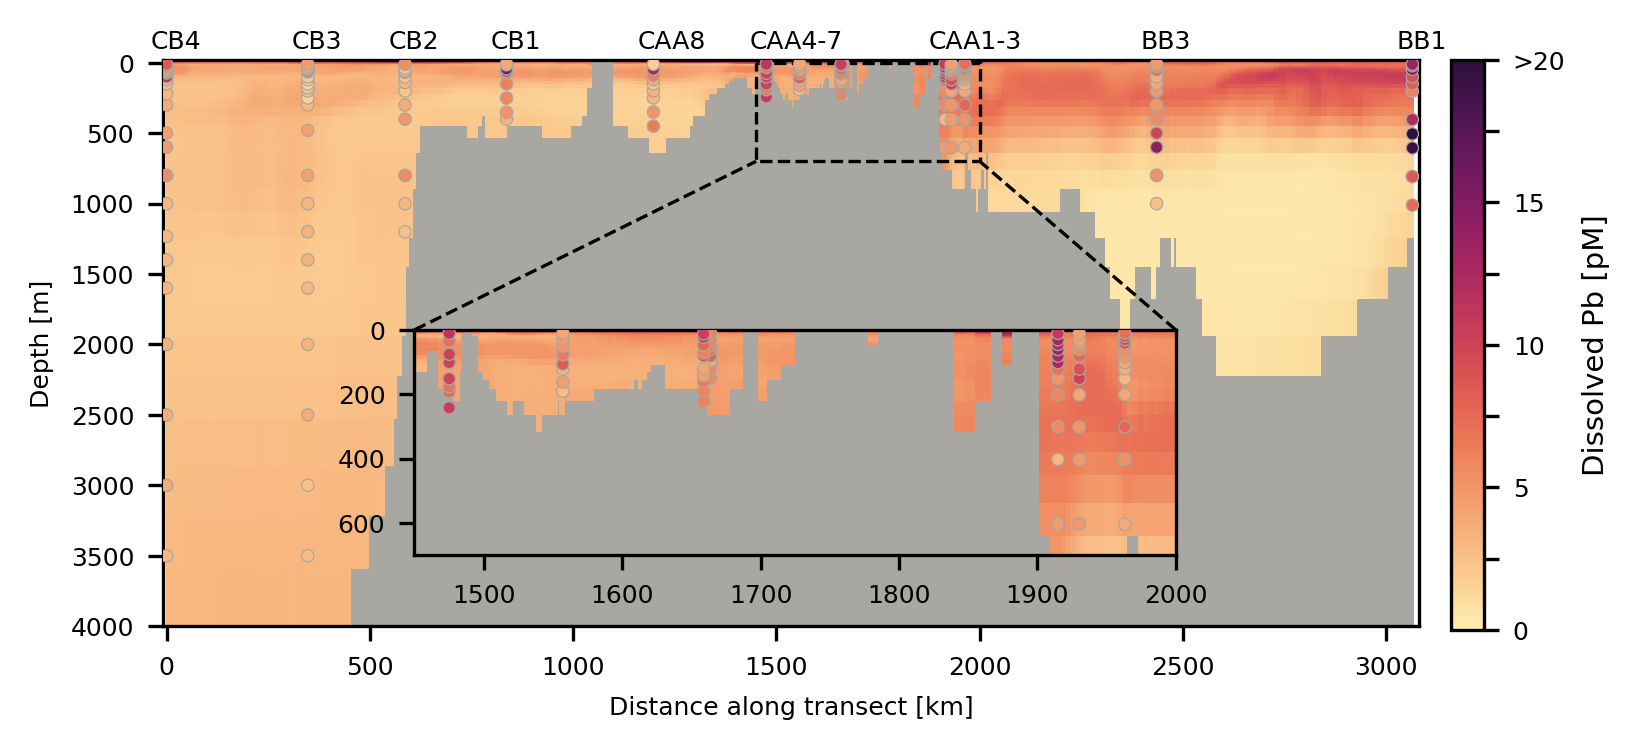

In [75]:
fig, ax = plt.subplots(1,1, figsize=(4.5*1.2, 2.5), dpi=300)

# limits for colorbar:
vminPb = 0 
vmaxPb = 20
pointsbg = '#173543'# outline color for scatterpoints

# set colormap with masked areas as land
cmap1 = cmocean.cm.matter
cmap1.set_bad(land_color, 1)
plot_dPb = np.ma.masked_where(transect_dissolved_pb == 0, transect_dissolved_pb)

# General plot --------------------------------------------------
for i in range(0,len(transect_lons)):
    sc = ax.scatter(transect_distances[i]*np.ones(26), transect_depths_r[:,i], \
                    vmin = vminPb, vmax = vmaxPb, c=transect_dPb_r[:,i]*1e3, cmap=cmocean.cm.matter,\
                    zorder = 4, s=35, marker='.', edgecolors=land_color, linewidths=0.3)
    ax.text(transect_distances[i]-40, -100, transect_names2[i], fontsize=6)
    
ax.invert_yaxis()
contour = ax.pcolormesh(transect_model_distances, depths_model, plot_dPb, vmin=vminPb, vmax=vmaxPb, cmap=cmap1, zorder=2)
ax.set_ylabel('Depth [m]', fontsize=6)
ax.set_xlabel('Distance along transect [km]', fontsize=6)
ax.set_ylim([4000, -20])
ax.set_xlim([-8, 3080])
ax.tick_params(axis='both', which='major', labelsize=6)

# Zoom in of shallow area(inset axes): ---------------------------------------------------------
inset_ax = fig.add_axes([.28, .22, .47, .3], facecolor='k')
for i in range(0,len(transect_lons)):
    sc = inset_ax.scatter(transect_distances[i]*np.ones(26), transect_depths_r[:,i], \
                       vmin = vminPb, vmax = vmaxPb, c=transect_dPb_r[:,i]*1e3, cmap=cmocean.cm.matter,\
                       zorder = 4, s=35, marker='.', edgecolors=land_color, linewidths=0.3)
    
inset_ax.invert_yaxis()
inset_ax.set_ylim([700, -1])
inset_ax.set_xlim([1450, 2000])
inset_ax.pcolormesh(transect_model_distances, depths_model, plot_dPb, vmin=vminPb, vmax=vmaxPb, cmap=cmap1)
inset_ax.tick_params(axis='both', which='major', labelsize=6)

# Colorbar:
cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Pb [pM]', fontsize=7) 
cbar_ax.tick_params(axis='both', which='major', labelsize=6)
cbar.ax.set_yticklabels(['0','','5','','10','','15','','>20']) 

# Mark inset:
mark_inset(ax, inset_ax, loc1=2, loc2=1, fc="none", ec='k', lw=0.8, linestyle='--', zorder=3);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R2-transect.jpg', bbox_inches='tight', dpi=300)